In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from scipy import stats

In [2]:
base = "./v4/"
clients_with = "30_issda"
wall_time = 1000

In [3]:
df = pd.read_csv("./v4_all.csv")

clients = df["clients"].unique()
clients = list(filter(lambda x: clients_with in x, clients))

df = df[(df["clients"].isin(clients))]
df = df[df["wall_time"] == wall_time]
df.oracle = df.oracle.apply(lambda x: ast.literal_eval(x))

#df.expe  =df.expe.apply(lambda x: x.replace("v3", "v4"))

df.head(5)

Unnamed: 0                                               expe  \
0           0  ./expes/v4_2021-03-18_issda_1000-prng-1-w1-p10...   
1           1  ./expes/v4_2021-03-18_issda_1000-prng-1-w1-p10...   
2           2  ./expes/v4_2021-03-18_issda_1000-prng-1-w1-p10...   
3           3  ./expes/v4_2021-03-18_issda_1000-prng-1-w1-p10...   
4           4  ./expes/v4_2021-03-18_issda_1000-prng-1-w1-p10...   

         clients  clients_size clients_subset  agg_size  agg_size_pc method  \
0  30_issda-1000           997     first-1000       350           35    rng   
1  30_issda-1000           999     first-1000       150           15    rng   
2  30_issda-1000           996     first-1000       400           40    rng   
3  30_issda-1000           995     first-1000       500           50    rng   
4  30_issda-1000          1000     first-1000        50            5    rng   

            days  days_size  ...  \
0  num-start-700        700  ...   
1  num-start-100        100  ...   
2  num-start-400        400  ...   
3  num-start-100        100  ...   
4  num-start-200        200  ...   

                                              oracle wall_hit  wall_time  \
0  [1, 7, 13, 16, 18, 19, 21, 23, 30, 31, 32, 33,...    False       1000   
1  [13, 14, 21, 27, 32, 35, 39, 45, 60, 65, 66, 7...    False       1000   
2  [1, 4, 6, 7, 8, 9, 13, 14, 16, 18, 19, 23, 25,...    False       1000   
3  [2, 4, 5, 6, 8, 12, 14, 16, 19, 21, 22, 23, 25...    False       1000   
4  [21, 32, 45, 65, 88, 92, 100, 117, 130, 141, 1...     True       1000   

   pooled  pool_size        uuid  infeasible  optimal  valid_sums  \
0    True        100  80d3cc7caa         0.0      1.0         0.0   
1    True        100  948cf0b6e7         0.0      1.0         0.0   
2    True        100  c7c1f6b3a5         0.0      1.0         0.0   
3    True        100  664a7754e5         0.0      1.0         0.0   
4    True        100  eec8f65841         0.0      0.0         0.0   

   days_size_pc  
0            70  
1            10  
2            40  
3            10  
4            20  

[5 rows x 30 columns]

In [4]:
df.iloc[0].oracle[0]

'1'

In [5]:
df_with_sols = df[df.nsols > 1]
df_with_sols.head(2)

Unnamed: 0                                               expe  \
0           0  ./expes/v4_2021-03-18_issda_1000-prng-1-w1-p10...   
1           1  ./expes/v4_2021-03-18_issda_1000-prng-1-w1-p10...   

         clients  clients_size clients_subset  agg_size  agg_size_pc method  \
0  30_issda-1000           997     first-1000       350           35    rng   
1  30_issda-1000           999     first-1000       150           15    rng   

            days  days_size  ...  \
0  num-start-700        700  ...   
1  num-start-100        100  ...   

                                              oracle wall_hit  wall_time  \
0  [1, 7, 13, 16, 18, 19, 21, 23, 30, 31, 32, 33,...    False       1000   
1  [13, 14, 21, 27, 32, 35, 39, 45, 60, 65, 66, 7...    False       1000   

   pooled  pool_size        uuid  infeasible  optimal  valid_sums  \
0    True        100  80d3cc7caa         0.0      1.0         0.0   
1    True        100  948cf0b6e7         0.0      1.0         0.0   

   days_size_pc  
0            70  
1            10  

[2 rows x 30 columns]

In [6]:
def compute_scores(x):
    path = os.path.join(base, x.expe[8:], "sols", x.uuid) + ".npy"
    
    oracle = list(x.oracle)
    scores = []
    freq = {}
    
    with open(path, "rb") as f:
        sols = np.load(f)
        
        for sol in sols:
            # Clients frequency
            for client in sol:
                if client not in freq:
                    freq[client] = 0
                freq[client] += 1                
            
            # Oracle score
            score = np.intersect1d(oracle, sol)
            
            score = len(score) / len(oracle)
            scores.append(score)
            
        for k in freq:
            freq[k] = freq[k] / len(sols)
            
        freqs = freq
        
        #for o in oracle:
        #    if o in freq:
        #        freqs[o] = freq[o]
        
        vals = [freqs[k] for k in freqs]
        if len(vals) > 0:
            m = max(vals)
        else:
            m = 0
    
    return pd.Series({
        "freqs": freq,
        "freqs_max": m,
        "random_guess": x.agg_size / x.clients_size,
        "scores": scores,
        "scores_mean": np.mean(scores),
        "scores_min": min(scores),
        "scores_max": max(scores)
    })

df_s = df_with_sols.merge(df_with_sols.apply(compute_scores, axis=1), left_index=True, right_index=True)
df_s

Unnamed: 0                                               expe  \
0             0  ./expes/v4_2021-03-18_issda_1000-prng-1-w1-p10...   
1             1  ./expes/v4_2021-03-18_issda_1000-prng-1-w1-p10...   
2             2  ./expes/v4_2021-03-18_issda_1000-prng-1-w1-p10...   
3             3  ./expes/v4_2021-03-18_issda_1000-prng-1-w1-p10...   
4             4  ./expes/v4_2021-03-18_issda_1000-prng-1-w1-p10...   
..          ...                                                ...   
995           2  ./expes/v4_2021-03-18_issda_1000-prng-1-w1-p10...   
996           3  ./expes/v4_2021-03-18_issda_1000-prng-1-w1-p10...   
997           4  ./expes/v4_2021-03-18_issda_1000-prng-1-w1-p10...   
998           5  ./expes/v4_2021-03-18_issda_1000-prng-1-w1-p10...   
999           6  ./expes/v4_2021-03-18_issda_1000-prng-1-w1-p10...   

           clients  clients_size clients_subset  agg_size  agg_size_pc method  \
0    30_issda-1000           997     first-1000       350           35    rng   
1    30_issda-1000           999     first-1000       150           15    rng   
2    30_issda-1000           996     first-1000       400           40    rng   
3    30_issda-1000           995     first-1000       500           50    rng   
4    30_issda-1000          1000     first-1000        50            5    rng   
..             ...           ...            ...       ...          ...    ...   
995  30_issda-1000           999     first-1000       150           15    rng   
996  30_issda-1000           998     first-1000       250           25    rng   
997  30_issda-1000           996     first-1000       400           40    rng   
998  30_issda-1000           998     first-1000       200           20    rng   
999  30_issda-1000           999     first-1000       100           10    rng   

               days  days_size  ...  optimal valid_sums  days_size_pc  \
0     num-start-700        700  ...      1.0        0.0            70   
1     num-start-100        100  ...      1.0        0.0            10   
2     num-start-400        400  ...      1.0        0.0            40   
3     num-start-100        100  ...      1.0        0.0            10   
4     num-start-200        200  ...      0.0        0.0            20   
..              ...        ...  ...      ...        ...           ...   
995  num-start-1000       1000  ...      1.0        0.0           100   
996   num-start-100        100  ...      1.0        0.0            10   
997   num-start-200        200  ...      1.0        0.0            20   
998   num-start-300        300  ...      1.0        0.0            30   
999  num-start-1000       1000  ...      0.0        0.0           100   

                                                 freqs  freqs_max  \
0    {'457': 0.58, '328': 0.29, '719': 0.74, '77': ...   1.000000   
1    {'973': 1.0, '199': 0.98, '152': 1.0, '240': 0...   1.000000   
2    {'145': 0.41, '486': 0.16, '587': 0.79, '90': ...   1.000000   
3    {'563': 0.48, '840': 0.51, '79': 0.38, '265': ...   1.000000   
4    {'679': 0.07407407407407407, '831': 0.81481481...   0.925926   
..                                                 ...        ...   
995  {'946': 0.06, '250': 1.0, '318': 1.0, '557': 1...   1.000000   
996  {'700': 0.51, '935': 0.82, '946': 0.08, '34': ...   1.000000   
997  {'476': 0.51, '123': 0.49, '21': 0.4, '649': 0...   0.990000   
998  {'420': 0.05, '117': 0.5, '501': 0.03, '708': ...   1.000000   
999  {'852': 1.0, '87': 1.0, '558': 0.25, '741': 0....   1.000000   

     random_guess                                             scores  \
0        0.351053  [0.9228571428571428, 0.9914285714285714, 0.354...   
1        0.150150  [0.12, 0.11333333333333333, 0.9666666666666667...   
2        0.401606  [0.92, 0.9875, 0.385, 0.385, 0.385, 0.385, 0.3...   
3        0.502513  [0.95, 0.988, 0.472, 0.472, 0.472, 0.472, 0.47...   
4        0.050000  [0.26, 0.22, 0.2, 0.22, 0.24, 1.0, 0.3, 0.2, 0...   
..            ...                                    

In [7]:
df_s.scores_mean.median()

0.34266666666666673

## For a single set of params (one specific expe)

In [8]:
single = df_s[(df_s.agg_size_pc == 25) & (df_s.days_size_pc == 80)].iloc[0, :]
single

Unnamed: 0                                                        0
expe              ./expes/v4_2021-03-18_issda_1000-prng-1-w1-p10...
clients                                               30_issda-1000
clients_size                                                    998
clients_subset                                           first-1000
agg_size                                                        250
agg_size_pc                                                      25
method                                                          rng
days                                                  num-start-800
days_size                                                       800
days_total                                                    25726
noise_method                                              ukn-95-99
time                                                      97.020783
valid                                                         False
valid_sum                                       

In [9]:
single.oracle

['2',
 '5',
 '9',
 '19',
 '22',
 '25',
 '26',
 '29',
 '32',
 '33',
 '37',
 '38',
 '42',
 '45',
 '47',
 '51',
 '58',
 '59',
 '61',
 '62',
 '70',
 '78',
 '85',
 '87',
 '94',
 '96',
 '105',
 '109',
 '116',
 '118',
 '131',
 '140',
 '144',
 '148',
 '156',
 '158',
 '161',
 '163',
 '166',
 '169',
 '171',
 '174',
 '177',
 '178',
 '181',
 '182',
 '187',
 '189',
 '196',
 '213',
 '216',
 '218',
 '228',
 '231',
 '233',
 '237',
 '242',
 '251',
 '254',
 '256',
 '258',
 '262',
 '266',
 '269',
 '271',
 '273',
 '275',
 '280',
 '286',
 '293',
 '311',
 '316',
 '317',
 '320',
 '324',
 '327',
 '333',
 '336',
 '346',
 '350',
 '353',
 '360',
 '363',
 '369',
 '370',
 '371',
 '372',
 '373',
 '376',
 '381',
 '383',
 '390',
 '395',
 '403',
 '410',
 '412',
 '417',
 '425',
 '430',
 '434',
 '442',
 '456',
 '457',
 '459',
 '460',
 '466',
 '468',
 '473',
 '477',
 '485',
 '492',
 '499',
 '501',
 '502',
 '511',
 '513',
 '515',
 '517',
 '520',
 '522',
 '523',
 '525',
 '527',
 '528',
 '531',
 '535',
 '536',
 '538',
 '539

In [10]:
single.freqs

{'800': 0.99,
 '473': 0.99,
 '520': 1.0,
 '576': 1.0,
 '938': 0.99,
 '333': 1.0,
 '311': 0.99,
 '32': 1.0,
 '346': 0.99,
 '572': 0.99,
 '511': 1.0,
 '502': 0.99,
 '38': 0.7,
 '371': 1.0,
 '856': 0.99,
 '350': 0.97,
 '148': 0.98,
 '978': 1.0,
 '981': 0.99,
 '527': 1.0,
 '144': 1.0,
 '536': 1.0,
 '466': 1.0,
 '369': 0.99,
 '70': 0.98,
 '213': 0.07,
 '733': 0.99,
 '254': 1.0,
 '459': 0.13,
 '22': 1.0,
 '754': 1.0,
 '995': 0.78,
 '327': 0.99,
 '870': 0.91,
 '161': 0.39,
 '262': 0.99,
 '964': 0.99,
 '324': 1.0,
 '668': 0.91,
 '558': 0.99,
 '33': 0.93,
 '412': 0.98,
 '460': 1.0,
 '698': 0.08,
 '370': 1.0,
 '880': 0.99,
 '604': 0.98,
 '852': 0.99,
 '535': 0.98,
 '620': 0.99,
 '884': 0.88,
 '948': 1.0,
 '943': 1.0,
 '25': 0.99,
 '973': 1.0,
 '372': 0.99,
 '774': 1.0,
 '631': 0.99,
 '920': 1.0,
 '237': 1.0,
 '216': 0.99,
 '87': 1.0,
 '881': 0.98,
 '256': 1.0,
 '457': 1.0,
 '320': 1.0,
 '251': 0.98,
 '955': 0.99,
 '485': 1.0,
 '440': 0.98,
 '803': 0.98,
 '521': 0.89,
 '224': 0.98,
 '75': 0.98,
 

### Frequency of all the individuals

In [11]:
def freqs_all_to_df(row):
    df = pd.DataFrame()
    
    freqs = row.freqs

    for k in freqs:
        v = freqs[k]
        
        df = df.append({
            "I": k,
            "Y": v
        }, ignore_index=True)
    return df

df_freq_all = freqs_all_to_df(single)
df_freq_all

I     Y
0    800  0.99
1    473  0.99
2    520  1.00
3    576  1.00
4    938  0.99
..   ...   ...
546  359  0.01
547  588  0.01
548  382  0.01
549  419  0.01
550  866  0.06

[551 rows x 2 columns]

In [12]:
df_freq_all[df_freq_all.Y < 1]

I     Y
0    800  0.99
1    473  0.99
4    938  0.99
6    311  0.99
8    346  0.99
..   ...   ...
546  359  0.01
547  588  0.01
548  382  0.01
549  419  0.01
550  866  0.06

[523 rows x 2 columns]

In [13]:
"'2736'" in single.oracle

False

[Text(0.5, 0, 'Υ (%)'), Text(0, 0.5, 'Individuals (%)')]

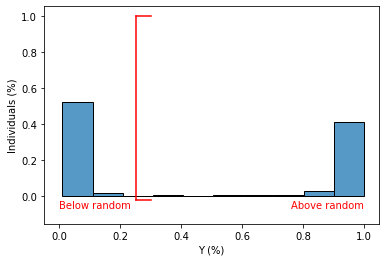

In [14]:
ax = sns.histplot(data=df_freq_all, x="Y", bins=10, stat="probability")

plt.plot([single.random_guess, single.random_guess], [1, -0.02], linewidth=1.5, color="red")
plt.plot([single.random_guess, single.random_guess + 0.05], [1, 1], linewidth=1.5, color="red")
plt.plot([single.random_guess, single.random_guess + 0.05], [-0.02, -0.02], linewidth=1.5, color="red")

plt.plot([0, 0], [0, -0.1], linewidth=1.5, color="white")

ax.text(0, -0.07, "Below random", horizontalalignment='left', size='medium', color='red')
ax.text(1, -0.07, "Above random", horizontalalignment='right', size='medium', color='red')

ax.set(xlabel="Υ (%)", ylabel="Individuals (%)")

### Frequency of all individuals in the oracle

/!\ L'oracle est foireux pour le moment

### Frequency of all individuals not in the oracle

In [15]:
def freqs_not_to_df(row):
    df = pd.DataFrame()
    
    freqs = {}
    
    for freq in row.freqs:
        if freq not in row.oracle:
            freqs[freq] = row.freqs[freq]
    
    
    for k in freqs:
        v = freqs[k]
        
        df = df.append({
            "I": k,
            "Y": v
        }, ignore_index=True)
    return df

df_freq_not = freqs_not_to_df(single)
df_freq_not

I     Y
0    440  0.98
1    803  0.98
2    521  0.89
3    224  0.98
4     75  0.98
..   ...   ...
298  359  0.01
299  588  0.01
300  382  0.01
301  419  0.01
302  866  0.06

[303 rows x 2 columns]

[Text(0.5, 0, 'Υ (%)'), Text(0, 0.5, 'Individuals (%)')]

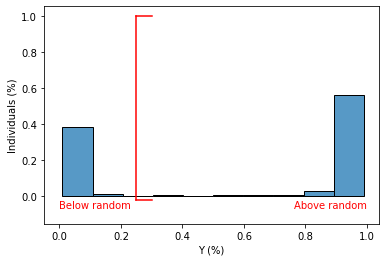

In [16]:
ax = sns.histplot(data=df_freq_not, x="Y", bins=10, stat="probability")

plt.plot([single.random_guess, single.random_guess], [1, -0.02], linewidth=1.5, color="red")
plt.plot([single.random_guess, single.random_guess + 0.05], [1, 1], linewidth=1.5, color="red")
plt.plot([single.random_guess, single.random_guess + 0.05], [-0.02, -0.02], linewidth=1.5, color="red")

plt.plot([0, 0], [0, -0.1], linewidth=1.5, color="white")

ax.text(0, -0.07, "Below random", horizontalalignment='left', size='medium', color='red')
ax.text(1, -0.07, "Above random", horizontalalignment='right', size='medium', color='red')

ax.set(xlabel="Υ (%)", ylabel="Individuals (%)")

## Frequency for the individuals (with the repetitions)

### All the individuals

In [17]:
batch = df_s[(df_s.agg_size_pc == 25) & (df_s.days_size_pc == 80)]
batch.head(2)

Unnamed: 0                                               expe  \
27           0  ./expes/v4_2021-03-18_issda_1000-prng-1-w1-p10...   
57           0  ./expes/v4_2021-03-18_issda_1000-prng-1-w1-p10...   

          clients  clients_size clients_subset  agg_size  agg_size_pc method  \
27  30_issda-1000           998     first-1000       250           25    rng   
57  30_issda-1000           998     first-1000       250           25    rng   

             days  days_size  ...  optimal valid_sums  days_size_pc  \
27  num-start-800        800  ...      1.0        0.0            80   
57  num-start-800        800  ...      1.0        0.0            80   

                                                freqs  freqs_max  \
27  {'800': 0.99, '473': 0.99, '520': 1.0, '576': ...        1.0   
57  {'639': 0.99, '146': 0.46, '183': 1.0, '633': ...        1.0   

    random_guess                                             scores  \
27      0.250501  [0.276, 0.268, 0.896, 0.992, 0.272, 0.276, 0.2...   
57      0.250501  [0.244, 0.256, 0.244, 0.252, 0.928, 0.992, 0.2...   

    scores_mean  scores_min  scores_max  
27      0.29096       0.252       0.992  
57      0.25788       0.232       0.992  

[2 rows x 37 columns]

In [29]:
def freqs_all_to_df(row):
    df = pd.DataFrame()
    bins = 10
    
    freqs = row.freqs

    for k in freqs:
        v = freqs[k]
        
        df = df.append({
            "I": k,
            "Y": v
        }, ignore_index=True)
    df.I = df.I.astype(int)
    
    
    df = df.groupby(pd.cut(df.Y, bins).rename("bins"))["Y"].count().reset_index()
    df.columns = ["Y", "I"]
    df.Y = [x for x in range(bins)]
    df.I = df.I / df.I.sum()
    
    return df

def freqs_all_batch(batch):
    df = None
    
    for i, row in batch.iterrows():
        d = freqs_all_to_df(row)
        
        if df is None:
            df = d
        else:
            break
            #df = pd.concat([df, d])
    
    return df
    

df_freqs_all = freqs_all_batch(batch)
df_freqs_all

Y         I
0  0  0.522686
1  1  0.014519
2  2  0.000000
3  3  0.007260
4  4  0.001815
5  5  0.007260
6  6  0.003630
7  7  0.003630
8  8  0.029038
9  9  0.410163

<AxesSubplot:xlabel='Y', ylabel='I'>

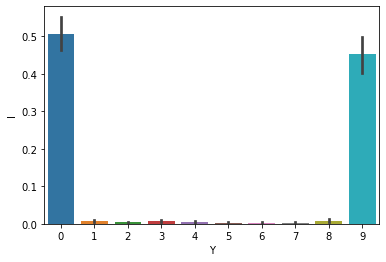

In [19]:
sns.barplot(data=df_freqs_all, x="Y", y="I")

### Only in the oracle

In [20]:
def freqs_in_row(row):
    df = pd.DataFrame()
    bins = 10
    
    freqs = {}
    
    for freq in row.freqs:
        if freq in row.oracle:
            freqs[freq] = row.freqs[freq]

    for k in freqs:
        v = freqs[k]
        
        df = df.append({
            "I": k,
            "Y": v
        }, ignore_index=True)
        df.I = df.I.astype(int)
    
    df = df.groupby(pd.cut(df.Y, bins).rename("bins"))["Y"].count().reset_index()
    df.columns = ["Y", "I"]
    df.Y = [x for x in range(bins)]
    df.I = df.I / df.I.sum()
    
    return df

def freqs_in_batch(batch):
    df = None
    
    for i, row in batch.iterrows():
        d = freqs_in_row(row)
        
        if df is None:
            df = d
        else:
            df = pd.concat([df, d])
    
    return df
    

df_freqs_in = freqs_in_batch(batch)
df_freqs_in

Y         I
0   0  0.689516
1   1  0.016129
2   2  0.000000
3   3  0.012097
4   4  0.004032
.. ..       ...
5   5  0.008065
6   6  0.000000
7   7  0.004032
8   8  0.000000
9   9  0.233871

[100 rows x 2 columns]

<AxesSubplot:xlabel='Y', ylabel='I'>

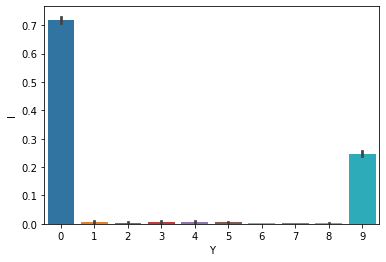

In [21]:
sns.barplot(data=df_freqs_in, x="Y", y="I")

### Not in the oracle

In [22]:
def freqs_out_row(row):
    df = pd.DataFrame()
    bins = 10
    
    freqs = {}
    
    for freq in row.freqs:
        if freq not in row.oracle:
            freqs[freq] = row.freqs[freq]

    for k in freqs:
        v = freqs[k]
        
        df = df.append({
            "I": k,
            "Y": v
        }, ignore_index=True)
        df.I = df.I.astype(int)
    
    df = df.groupby(pd.cut(df.Y, bins).rename("bins"))["Y"].count().reset_index()
    df.columns = ["Y", "I"]
    df.Y = [x for x in range(bins)]
    df.I = df.I / df.I.sum()
    
    return df

def freqs_out_batch(batch):
    df = None
    
    for i, row in batch.iterrows():
        d = freqs_out_row(row)
        
        if df is None:
            df = d
        else:
            df = pd.concat([df, d])
    
    return df
    

df_freqs_out = freqs_out_batch(batch)
df_freqs_out

Y         I
0   0  0.386139
1   1  0.013201
2   2  0.000000
3   3  0.003300
4   4  0.000000
.. ..       ...
5   5  0.000000
6   6  0.000000
7   7  0.004673
8   8  0.004673
9   9  0.864486

[100 rows x 2 columns]

<AxesSubplot:xlabel='Y', ylabel='I'>

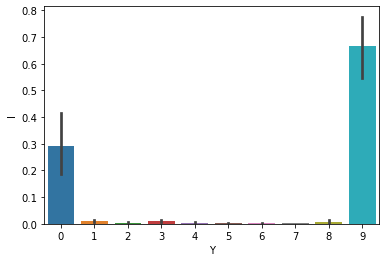

In [23]:
sns.barplot(data=df_freqs_out, x="Y", y="I")